# Is this a cat or a keyboard?

Run the below in the venv to make sure everything is installed beforehand

`pip install -Uqq fastai 'duckduckgo_search>=6.2'`

`pip install -U fastcore`

## Setup

In [2]:
import socket,warnings
import os
import time, json
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.vision.all import *

## Collect Images

First we download an image of a cat and see how it looks

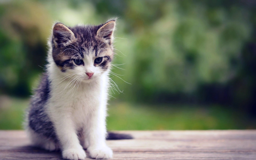

In [28]:
# use duckduckgo_search to grab images
def search_images(keyword, max_images=200):
    return L(DDGS().images(keyword, max_results=max_images)).itemgot('image')

# grab 1 cat pic
urls = search_images('cat', max_images=1)
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)
cat_img = Image.open(dest)
cat_img.to_thumb(256,256)

Next let's download an image of a keyboard too

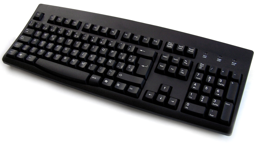

In [29]:
# grab 1 keyboard pic
download_url(search_images('keyboard', max_images=1)[0], 'keyboard.jpg', show_progress=False)
key_img = Image.open('keyboard.jpg').to_thumb(256,256)
key_img.to_thumb(256,256)

Now let's download a bunch more pictures of cats and keyboards. These will be saved to their own seperate folders in this directory. This might take a sec...

In [30]:
searches = 'cat','keyboard'
path = Path('cat_or_keyboard')

# download
for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{i} photo'))
    time.sleep(5)
    resize_images(path/i, max_size=400, dest=path/i)

/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/pbwz/repos/data-

## Train the model

Check if all the images downloaded properly. Then we get rid of any bad downloads so they don't mess with our model training

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/python3.12/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/home/pbwz/repos/data-science/.venv/lib/

33

Now to train the model we use DataLoaders. This will use a training set and a validation set. 

Remember the validation set is never used during training. It is only used for eval after each epoch.

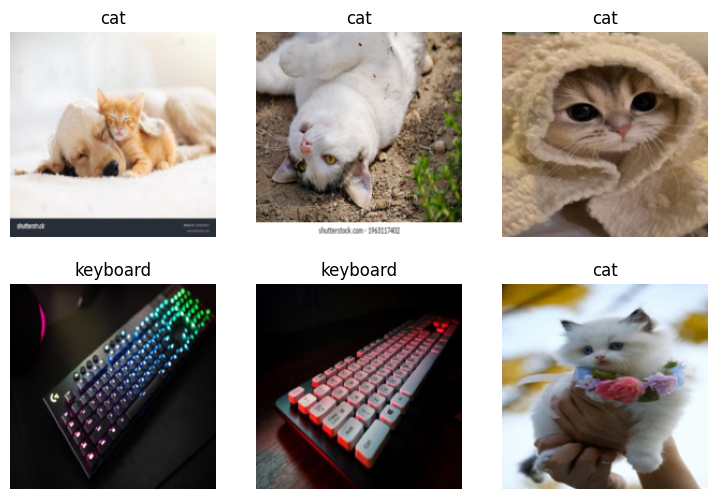

In [16]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192, method='squish')]
).dataloaders(path, bs=32)

# peek at some images
dls.show_batch(max_n=6)

### DataBlock cheat code

`blocks = (ImageBlock, CategoryBlock),`

The model input will be images and we want categories for our output ("cat" and "keyboard")

`get_items = get_image_files,`

This will get all of the image files in whatever we set as `path`.

`splitter = RandomSplitter(valid_pct=0.2, seed=42),`

Now we split 20% of our data into the validation set.

`get_y = parent_label,`

Set the name of the parent of each file ("cat" or "keyboard")

`item_tfms=[Resize(192, method='squish')]`

Squish each image down to 192 x 192 px.


**And now we actually train...**

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

# train up to 20 epochs. stop early if no longer improving
learn.fine_tune(
    20, 
    cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3)  # wait at least 3 epochs
)

epoch,train_loss,valid_loss,error_rate,time
0,0.274242,0.004202,0.003953,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.013282,0.000312,0.000000,00:06
1,0.006701,0.000185,0.000000,00:02
2,0.004987,0.001030,0.000000,00:02
3,0.007846,0.002118,0.000000,00:02
4,0.008249,0.017982,0.003953,00:02


No improvement since epoch 1: early stopping


## Lets try it out

Now we can use our model to check if that cat we downloaded earlier is actually a cat...

This is a: cat
with probability: 0.999975


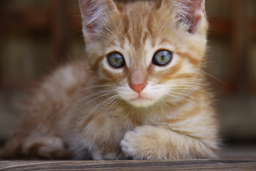

In [18]:
# predict if cat or keyboard with a probability
guess, _, prob = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {guess}")
print(f"with probability: {prob[0]:.6f}")

cat_img.to_thumb(256,256)   # show starting cat

Or a keyboard...

This is a: keyboard
with probability: 1.000000


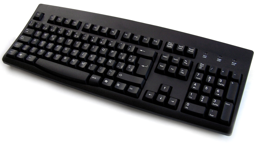

In [ ]:
# predict if cat or keyboard with a probability
guess, _, prob = learn.predict(PILImage.create('keyboard.jpg'))
print(f"This is a: {guess}")
print(f"with probability: {prob[1]:.6f}")

key_img.to_thumb(256,256)   # show starting keboard

Or run this cell to try an image saved at `test.jpg`

This is a: cat
with probability: 0.999999


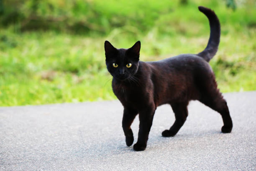

In [ ]:
test_file = 'test.jpg'
guess, _, prob = learn.predict(PILImage.create(test_file))
print(f"This is a: {guess}")
print(f"with probability: {max(prob):.6f}")

# show image
test_img = Image.open(test_file)
test_img.to_thumb(256,256)

### END